# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Fine Tune GPT Model

In [1]:
import os 
import re
import math 
import json 
import random 
from dotenv import load_dotenv
from huggingface_hub import login 
import matplotlib.pyplot as plt 
import numpy as np 
import pickle 
from collections import Counter
### LLM models 
from openai import OpenAI
from anthropic import Anthropic

### Intrnal Classes
from items import Item 
from testing import Tester 

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
### Environment 

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN = os.getenv("HF_TOKEN")

login(HF_TOKEN, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
%matplotlib inline

In [4]:
openai_client = OpenAI() 
claude_client = Anthropic()

In [84]:
### Load pickle files of data

with open("train.pkl", "rb") as f: 
    train = pickle.load(f)

with open("test.pkl", "rb") as f: 
    test = pickle.load(f)

In [85]:
len(train)

150000

In [86]:
test[0]

<A-Tech 8GB Memory RAM for Toshiba Satellite P875-S7102 - DDR3 1333MHz PC3-10600 Non ECC SO-DIMM 2Rx8 1.5V - Single Laptop & Notebook = $28.99>

In [88]:
random.shuffle(test)

test[0]

<Sony WH1000XM2 Premium Noise Cancelling Wireless Headphones ? Black (WH1000XM2/B) (Renewed) = $299.0>

In [92]:
### OpenAI recommends fine-tuning with populations of 50-100 examples
### But as the examples I am using is very small, so I will go with 200 examples (and 1 epoch)


### Shuffle data arrangement in the train dataset to select train data randomly
random.shuffle(train)

fine_tune_train = train[:800]
fine_tune_validation = train[800: 1000]

print(len(fine_tune_train))
print(len(fine_tune_validation))

print(fine_tune_train[10])
print(fine_tune_validation[10])



800
200
<Atdec SD-DP-750 Spacedec Donut Pole Mount with Quick Release Mechanism and 75x75/100x100mm VESA Support, 29.5-Inch, Black = $149.11>
<KAIWEIDI ELPLP78/V13H010L78 Projector Lamp for Epson PowerLite S17 S18+ W15+ W17 W18+ X17 X24+ 99W ,VS230 VS330 VS335W EX3220 EX5220 EB950W EB955W EB-W18 EB-X25 EH-TW410 Projectors = $31.99>


## Step 1 -- Preparing Data

Prepare the data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [93]:
def messages_for(item):
    system_message = "You estimate the price of item. Reply only with the price without any additional explanation or comment."
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [94]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...

def make_jsonl(items): 
    result = ""
    for item in items: 
        messages = messages_for(item)
        msg_json = json.dumps(messages)
        result += '{"messages": '+ msg_json +'}\n'

    return result.strip()

In [95]:
### Write items to jsonl files

def write_jsonl(items, filename): 
    with open(filename, "w") as f: 
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [100]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [101]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [102]:
### Upload the train file to OpenAI 

with open("fine_tune_train.jsonl", "rb") as f: 
    train_file = openai_client.files.create(file=f, purpose="fine-tune")

In [103]:
train_file

FileObject(id='file-UaPZPqvSxy7aLwZ9pU1qsc', bytes=775206, created_at=1763190693, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [104]:
### Upload the validation file to OpenAI 

with open("fine_tune_validation.jsonl", "rb") as f: 
    validation_file = openai_client.files.create(file=f, purpose="fine-tune")

In [122]:
validation_file

FileObject(id='file-3W4g8FYNCrPeYKvC3sVop8', bytes=190687, created_at=1763190709, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

## Step 2 -- Fine Tune

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.


In [106]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-fine-tuning", "entity": "mh-hong-personal-org"}}

In [107]:
openai_client.fine_tuning.jobs.create(
    training_file=train_file.id, 
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18", 
    seed=42, 
    hyperparameters={"n_epochs": 2}, 
    integrations= [wandb_integration], 
    suffix="pricer"
)

FineTuningJob(id='ftjob-ENFKPchGWVYsd4vYv8vxnkgM', created_at=1763190865, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=2), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-14kuOB4rpvyQ7RSuvSs1VXdL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-UaPZPqvSxy7aLwZ9pU1qsc', validation_file='file-3W4g8FYNCrPeYKvC3sVop8', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-fine-tuning', entity='mh-hong-personal-org', name=None, tags=None, run_id='ftjob-ENFKPchGWVYsd4vYv8vxnkgM'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=2))), user

In [108]:
openai_client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-ENFKPchGWVYsd4vYv8vxnkgM', created_at=1763190865, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=2), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-14kuOB4rpvyQ7RSuvSs1VXdL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-UaPZPqvSxy7aLwZ9pU1qsc', validation_file='file-3W4g8FYNCrPeYKvC3sVop8', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-fine-tuning', entity='mh-hong-personal-org', name=None, tags=None, run_id='ftjob-ENFKPchGWVYsd4vYv8vxnkgM'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_mu

In [113]:
job_id = openai_client.fine_tuning.jobs.list(limit=1).data[0].id
print(job_id)

ftjob-ENFKPchGWVYsd4vYv8vxnkgM


In [110]:
openai_client.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-ENFKPchGWVYsd4vYv8vxnkgM', created_at=1763190865, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=2), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-14kuOB4rpvyQ7RSuvSs1VXdL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-UaPZPqvSxy7aLwZ9pU1qsc', validation_file='file-3W4g8FYNCrPeYKvC3sVop8', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-fine-tuning', entity='mh-hong-personal-org', name=None, tags=None, run_id='ftjob-ENFKPchGWVYsd4vYv8vxnkgM'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=2))), user

In [126]:
openai_client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=1).data

[FineTuningJobEvent(id='ftevent-lzBuSAU6umm3CN4ZSvX8dciN', created_at=1763194181, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')]

## Step 3 - Test the fine tuned model

In [127]:
fine_tuned_model_id = openai_client.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [128]:
def messages_for(item): 
    system_message = "You estimate the price of item. Reply only with the price without any additional explanation or comment."
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("Price is $", "")

    return [
        {"role": "system", "content": system_message}, 
        {"role": "user", "content": user_prompt}, 
        {"role": "assistant", "content": "Price is $"} # little trick to encourage the response followed in this form
    ]

In [129]:
print(messages_for(train[0]))

[{'role': 'system', 'content': 'You estimate the price of item. Reply only with the price without any additional explanation or comment.'}, {'role': 'user', 'content': 'How much does this cost?\n\nMain_Category: Computers\n\nBlack Wristband USB Flash Memory Drive 8GB\nThe premium quality, true capacity 8GB flash drive is molded inside a flexible silicon wristband for convenient and secured carrage of your data. The wristband is 8-1/2" long when extended. Customer\'s satisfaction is assured with 14 days return money back guarantee and a one year replacement warranty. "We are dedicated to fast shipping and customer service" Premium true capacity 8GB wristband flash drive Supports USB 2.0 and compatible with USB 1.1  "Package Dimensions"  "4 x 4 x 1 inches", "Item Weight"  "0.8 ounces", ""  "Seatech", "Item model number"  "Is Discontinued By "  "No\n\n'}, {'role': 'assistant', 'content': 'Price is $'}]


In [130]:
### a utility function that extracts the price (float) 
### out of LLM's responses

def get_price(s: str): 
    s = s.replace("$", "").replace(",", "")
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [131]:
get_price("The product is around $199 blahblahblah")

199.0

In [132]:
### fine tuned based in GPT 4o mini

def test_fine_tuned_model(item):
    completion = openai_client.chat.completions.create(
        model=fine_tuned_model_id, 
        messages=messages_for(item), 
        max_tokens=5,
        seed=42
    )

    response = completion.choices[0].message.content

    return get_price(response)

In [133]:
### Manual Test

# Ground Truth 
test[100].price

149.0

In [134]:
# Fine tuned model prediction
test_fine_tuned_model(test[100])

274.0

In [135]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Main_Category: Cell Phones & Accessories

Sony Premium Noise Cancelling Wireless Headphones? Black (Renewed)
PRODUCT OVERVIEWListen to your playlist in peace with these Sony headphones. They have a 40mm dome driver to deliver the full depth of audio, and the noise-canceling feature minimizes outside disturbances for a better listening experience. These Sony headphones have a battery life of up to 30 hours for extended jam sessions.KEY FEATURESDIGITAL NOISE CANCELATION  Industry-leading noise canceling eliminates distracting background noisesSMART LISTENING  Quickly detects your activity to automatically adjust the ambient sounds you hearQUICK ATTENTION MODE  Cover the right ear cup to turn down your music for instant, easy conversation; Battery Charge Time  Approx. 4 hoursTOUCH CONTROL  Skip a track, change the volume and take or make

Price is $


1: Guess: $188.00 Truth: $299.00 Error: $111.00 SLE: 0.21 Item: Sony WH1000XM2 Premium Noise Cancelling ...
2: Guess: $77.00 Truth: $99.80 Error: $22.80 SLE: 0.07 Item: BRIGHTFOCAL New Screen Replacement for S...
3: Guess: $143.00 Truth: $229.95 Error: $86.95 SLE: 0.22 Item: (10) Rockville HC85 8" Inch 700 Watt In-...
4: Guess: $469.00 Truth: $243.09 Error: $225.91 SLE: 0.43 Item: HP Elite SFF Desktop Computer PC, Intel ...
5: Guess: $274.00 Truth: $279.00 Error: $5.00 SLE: 0.00 Item: Acer 2021 Chromebook Spin 11.6 Inch Touc...
6: Guess: $19.00 Truth: $37.99 Error: $18.99 SLE: 0.45 Item: Lightning to HDMI Adapter Apple MFi Cert...
7: Guess: $42.00 Truth: $32.99 Error: $9.01 SLE: 0.06 Item: AHUWFSU Halloween Men Jack Backpack, 3d ...
8: Guess: $19.00 Truth: $124.00 Error: $105.00 SLE: 3.36 Item: R RACKMOUNT·IT | RM-CI-T4 | Rack Mountin...
9: Guess: $469.00 Truth: $449.00 Error: $20.00 SLE: 0.00 Item: Lenovo Ideapad Flex 15 59395208
10: Guess: $139.00 Truth: $154.90 Error: $15.90 SLE: 0.

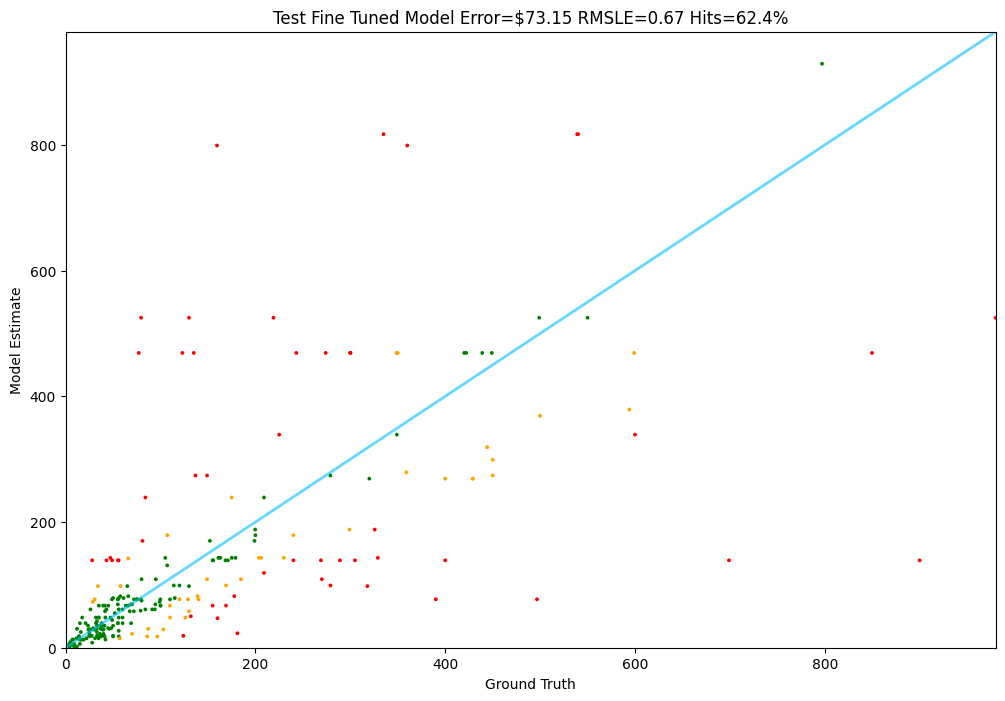

In [136]:
Tester.test(test_fine_tuned_model, test)